<a href="https://colab.research.google.com/github/Tianananana/MAML-Naive-Walkthrough/blob/main/v1_MAML_P%26P_(Autograd).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## V1 CHANGES (6/1/2023):
TODO:
- ET, LW, HK: Print compute tree. Take ref from here: https://github.com/szagoruyko/pytorchviz

DONE:
- add Loss class
- add optimizer
- figure out how to compute gradient in single step (no chain rule)



In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=a7ae6fe815b25fbd361532ec0a8e9993e45e156c6368a8296ad6211f8ae25200
  Stored in directory: /root/.cache/pip/wheels/05/7d/1b/8306781244e42ede119edbb053bdcda1c1f424ca226165a417
Successfully built torchviz


In [ ]:
import torch
import numpy as np
from torchviz import make_dot, make_dot_from_trace

tensor([5.], grad_fn=<MulBackward0>)


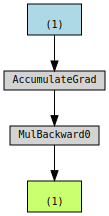

In [ ]:
net_test = SingleNet()
print(net_test(5))
make_dot(net_test(5), params={"weight": net.weight})

## Classes

In [ ]:
class SingleNet():
  def __init__(self):
    theta = torch.tensor([1.], requires_grad=True) # we will need the gradients of meta model weights.
    theta.retain_grad()
    self.weight = theta # set initial weight to 1
    # self.weight.retain_grad()
  
  def __call__(self, x, phij=None):
    if phij is None:
      return self.weight * x
    else:
      # manally pass in task-specific weights
      return phij * x
  
  def zero_grad(self):
    if self.weight.grad is None:
      self.weight.grad = torch.tensor([0.])
    self.weight.grad = self.weight.grad.zero_()

In [ ]:
class Loss():
  def __init__(self):
    pass

  def L1loss(self, pred, targ):
    loss = torch.sum((pred - targ)**2)
    return loss

  def __call__(self, pred, targ):
    return self.L1loss(pred, targ)

In [ ]:
class OptimSGD():
  def __init__(self, net, lr):
    self.net = net
    self.lr = lr

  def SGD(self):
    # SGD formula
    self.net.weight = self.net.weight - self.lr * self.net.weight.grad

  def step(self):
    self.SGD()

## v1 New pipeline with SingleNet, Loss, and Optim class

### Define Inner Trainer: compute task-specific weights (phi_j)

In [ ]:
class InnerTrainer:
  def __init__(self, net, lr, criterion):
    self.net = net
    self.alpha = alpha
    self.loss = criterion

  def one_inner_epoch(self, x, y):
    """ Returns phi_j """
    self.net.zero_grad()
    pred = self.net(x) # use theta (meta-model weights)
    loss = self.loss(pred, y)
    gradient = torch.autograd.grad(loss, self.net.weight, create_graph=True)[0]
    print(f"INNER GRADIENT: {gradient}")
    # computing phi_j
    inner_weight = self.net.weight - self.alpha * gradient
    print(f"PHI_J: {inner_weight}")
    print(f"PHI_J GRAD: {self.net.weight.grad}")
    return inner_weight

### Define Meta Trainer: update meta weight (theta)

In [ ]:
class MetaTrainer:
  def __init__(self, net, alpha, beta, criterion):
    self.net = net
    self.loss = criterion
    self.innerTrainer = InnerTrainer(net=net, lr=alpha, criterion=criterion)
    self.opt = OptimSGD(self.net, beta)

  def one_epoch(self, datasets):
    loss_all = torch.tensor([0.])
    self.net.zero_grad()
    for i in range(len(datasets)):
      # iterate over each dataset (D1, D2)
      print(f"RUNNING INNER LOOP OF D{i+1}")
      sx, sy = datasets[i]['support'][:, 0], datasets[i]['support'][:, 1]
      qx, qy = datasets[i]['query'][:, 0], datasets[i]['query'][:, 1]
      phi_j = self.innerTrainer.one_inner_epoch(sx, sy)
      pred = self.net(qx, phi_j)
      loss = self.loss(pred, qy)
      print(f"LOSS OVER QUERY: {loss}")
      loss_all += loss

    loss_all.backward()

    print(f"BEF STEP: {self.net.weight.grad=}")

    # update meta weights (theta)
    self.opt.step()

    print(f"AFT STEP: {self.net.weight.grad=}")
    print(f"{self.net.weight=}")

In [ ]:
alpha = 0.1
beta = 0.5
net = SingleNet()
L1 = Loss()

In [ ]:
# We define 2 datasets for our case. 
D1 = {'query': torch.tensor([(1, 2)], dtype=torch.int64), 'support': torch.tensor([(2, 4), (3, 1)])} # (x, y) pairs for query (Q1) and support (S1) set.
D2 = {'query': torch.tensor([(4, 1)], dtype=torch.int64), 'support': torch.tensor([(5, 3), (6, 0)])}
D_all = [D1, D2]
print(f"x_D1 (support set): {D1['support'][:,0]}")  # x
print(f"y_D1 (support set): {D1['support'][:,1]}")  # y

x_D1 (support set): tensor([2, 3])
y_D1 (support set): tensor([4, 1])


In [ ]:
trainer = MetaTrainer(net=net, alpha=alpha, beta=beta, criterion=L1)
trainer.one_epoch(D_all)

RUNNING INNER LOOP OF D1
INNER GRADIENT: tensor([4.], grad_fn=<SumBackward1>)
PHI_J: tensor([0.6000], grad_fn=<SubBackward0>)
PHI_J GRAD: tensor([0.])
LOSS OVER QUERY: 1.959999918937683
RUNNING INNER LOOP OF D2
INNER GRADIENT: tensor([92.], grad_fn=<SumBackward1>)
PHI_J: tensor([-8.2000], grad_fn=<SubBackward0>)
PHI_J GRAD: tensor([0.])
LOSS OVER QUERY: 1142.43994140625
BEF STEP: self.net.weight.grad=tensor([3032.9600])
AFT STEP: self.net.weight.grad=None
self.net.weight=tensor([-1515.4800], grad_fn=<SubBackward0>)


<ipython-input-68-1be479516587>:29: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:480.)
  print(f"AFT STEP: {self.net.weight.grad=}")


## v0 Old code (Loss functions, task-specific functions, meta functions)

In [ ]:
""" LOSS FUNCTIONS """
def loss(weight, dataset, mode='train'):
  # Eqn 5: l1 loss
  if mode == 'train':
    data = dataset['support']
  if mode == 'test':
    data = dataset['query']
    # HK: loss function need to pass in only pred and target.
  return torch.sum((data[:, 1] - weight * data[:, 0])**2)

In [ ]:
""" TASK SPECIFIC FUNCTIONS """
def inner_gradient(weight, dataset, mode='train'):
  # Eqn 6
  if mode == 'train':
    data = dataset['support']

  if mode == 'test':
    data = dataset['query']

  # HK: Only pass in dataset
  # add in loss variable
  

  # Use torch.autograd.grad
  return grad(loss(weight, dataset, mode=mode), weight, create_graph=True)[0]
  # return grad(loss(weight, dataset, mode=mode), weight)[0]
  
def inner_weight(weight, dataset, alpha=0.1, mode='train'):
  # Eqn 7
  task_specific_grads = inner_gradient(weight, dataset, mode=mode)
  return weight - alpha * task_specific_grads

In [ ]:
""" META FUNCTIONS """
def meta_gradient_1(theta_0, dataset):
  """ dag term: derivative of phi_j wrt theta_0 """
  phi_j_test = inner_weight(theta_0, dataset, mode='test')
  # Use torch.autograd.grad
  grad_wrt_theta_0 = grad(phi_j_test, theta_0)[0]
  return grad_wrt_theta_0

def meta_gradient_2(phi_j, dataset):
  """ ddag term: derivative wrt phi_j """
  meta_loss = loss(phi_j, dataset, mode='test')
  # Use torch.autograd.grad
  grad_wrt_phi_j = grad(meta_loss, phi_j)[0]
  return grad_wrt_phi_j


def meta_gradient(theta_0, dataset):
  """ Getting meta_gradient by applying chain rule """
  dag_term = meta_gradient_1(theta_0, dataset)
  phi_j = inner_weight(theta_0, dataset, mode='train')
  ddag_term = meta_gradient_2(phi_j, dataset)
  # use the chain rule
  return dag_term * ddag_term

def meta_loss(theta_0, dataset, alpha=0.1, beta=0.5):
  """ Computing the meta loss with meta gradients """
  total_grads = torch.tensor([0.])
  for d in dataset:
    total_grads += meta_gradient(theta_0, d)
  return theta_0 - beta * total_grads


In [ ]:
dataset = D1
net = SingleNet()
phi_j_test = inner_weight(net.weight, dataset, mode='test')
phi_j_train = inner_weight(net.weight, dataset, mode='train')
meta_loss = loss(phi_j_train, dataset, mode='test')
print(meta_loss)
meta_loss.backward()
phi_j_train.backward()
print(net.weight.grad)
print(phi_j_train)
print(meta_loss.grad_fn(phi_j_train))

tensor(1.9600, grad_fn=<SumBackward0>)
tensor([-1.8000])
tensor([0.6000], grad_fn=<SubBackward0>)
tensor([0.6000], grad_fn=<ExpandBackward0>)


In [ ]:
## UNIT TEST ##
net = SingleNet()
# Output task-specific gradient
inner_grad1 = inner_gradient(net.weight, D1, mode='train')
inner_grad2 = inner_gradient(net.weight, D2, mode='train')
print(f"{inner_grad1=}")
print(f"{inner_grad2=}")
print("")

# Output task-specific weights
w1 = inner_weight(net.weight, D1)
w2 = inner_weight(net.weight, D2)
print(f"{w1=}")
print(f"{w2=}")
print("")

# Output meta gradient
meta_grad1 = meta_gradient(net.weight, D1)
meta_grad2 = meta_gradient(net.weight, D2)
print(f"{meta_grad1}")
print(f"{meta_grad2}")
print("")

# Output new meta weight
theta_1 = meta_loss(net.weight, D_all)
print(f"{theta_1=}")
print("")

inner_grad1=tensor([4.], grad_fn=<SumBackward1>)
inner_grad2=tensor([92.], grad_fn=<SumBackward1>)

w1=tensor([0.6000], grad_fn=<SubBackward0>)
w2=tensor([-8.2000], grad_fn=<SubBackward0>)

tensor([-2.2400])
tensor([594.8800])

theta_1=tensor([-295.3200], grad_fn=<SubBackward0>)

